# Lab 3 – Introduction to CNNs with PyTorch

---

How to Use This Notebook
---

**Recommended Setup**
- For the best experience, **run this notebook on [Google Colab](https://colab.research.google.com/)**—especially if your local machine is slow.  
- In Colab, **enable GPU support** by going to:  
  `Runtime > Change runtime type > Hardware accelerator > GPU`


**Homework Tasks**

 - Homework tasks are clearly marked throughout the notebook in the following format:

   > ---

   > <span style="color:red"><b>TASK X</b> - [<i>some text</i>]:</span>

   > ---

   > ```Your code ....```

   > ---

   > *End of Task X.* [*Instructions for passing*]

 - For each task:
   - **Complete the code** where indicated.
   - **Upload the required results** from each task to **Homework 2 – Code** on [NextIlearn](https://nextilearn.dsv.su.se).

 - Once you've finished all the tasks:
   Submit your **entire completed notebook (including your code!)** to **Homework 2 – Notebook** on [NextIlearn](https://nextilearn.dsv.su.se).

**Important:**  
Your submission will **only be graded if both files** (code + notebook) are uploaded **before the deadline**. Late submissions are **not accepted**, regardless of technical issues like bad internet connection.

---




In this lab, we will explore **Convolutional Neural Networks (CNNs)** using **PyTorch**. This lab is hands-on and designed to be run during class time. Each step is followed by detailed explanations and code examples.





## Objectives
- Understand CNN architecture and its components
- Load and preprocess image data using PyTorch
- Build and train a simple CNN
- Evaluate performance on a test set

### Larger and more complex image dataset

In Fashion MNIST classification, the subject is always in the center of a 28x28 image. This means the network only needs to get important features from a fixed area.

However, in this section, we  will use the **CIFAR-10** dataset which contains 60,000 32x32 color images (RGB) in 10 classes, with 6,000 images per class. We will train a Convolutional Neural Network to recognize features in an image where the subject can be anywhere, and the network is trained to recognize features that determine which is which.

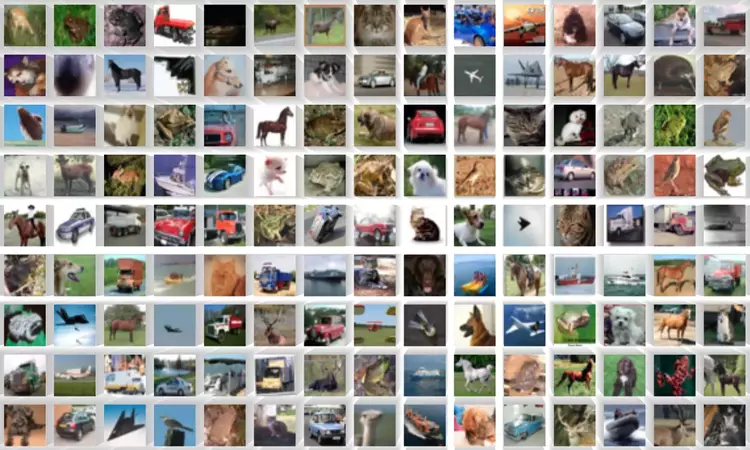

In [1]:
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Step 1: Load and Transform the CIFAR-10 Dataset

CIFAR-10 is a collection of 60,000 32x32 color images in 10 classes, with 6,000 images per class.
We will:
- Normalize the images to have zero mean and unit variance
- Use PyTorch's built-in dataset and dataloader utilities
- Load both training and test sets

### Normalization
Here, we apply transformations to resize images, convert them to tensors, and normalize. Then we load the CIFAR-10 dataset and preparing DataLoader for batch processing.

In [2]:
# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL Image to Tensor
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # Normalize RGB channels
])

In [3]:
# Download the CIFAR-10 training dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Download the CIFAR-10 test dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

100%|██████████| 170M/170M [00:04<00:00, 42.4MB/s]


In [4]:
# Class names for CIFAR-10 labels
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [5]:
# Split the training dataset into training and validation sets (e.g., 80% train, 20% val)
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
train_subset, val_subset = torch.utils.data.random_split(trainset, [train_size, val_size])

In [6]:
# Create DataLoaders for training, validation and test subsets
trainloader = torch.utils.data.DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

## Step 2: Visualize Some Images

Before training our CNN, it's helpful to **visualize the data** we're working with.
We'll define a helper function to show a few sample images along with their corresponding labels.

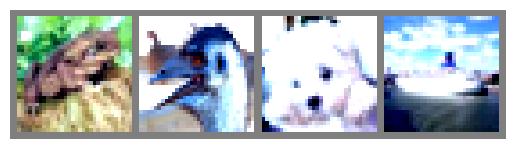

frog bird dog ship


In [11]:
# Helper function to unnormalize and show an image
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize from [-1, 1] to [0, 1]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Convert from CHW to HWC for plotting
    plt.axis('off')
    plt.show()

# Get a batch of training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show the first 4 images from the batch
imshow(torchvision.utils.make_grid(images[:4]))
# Print the corresponding class labels
print(' '.join(f'{classes[labels[j]]}' for j in range(4)))

## Step 3: Define a Simple Convolutional Neural Network

We define our CNN model using `nn.Module`. It consists of:
- One convolutional layer followed by ReLU and max pooling
- Two fully connected layers

This simple architecture is good for learning and experimentation.

##How Convolutional Neural Networks Work?


Convolutional neural networks (CNNs) are commonly used for image classification tasks. At a high level, CNNs contain three main types of layers:

- Convolutional layers: Apply convolutional filters to the input to extract features. The neurons in these layers are called filters and capture spatial patterns in the input.
- Pooling layers: Downsample the feature maps from the convolutional layers to consolidate information. Max pooling and average pooling are commonly used strategies.
- Fully-connected layers: Take the high-level features from the convolutional and pooling layers as input for classification. Multiple fully-connected layers can be stacked.

The convolutional filters act as feature detectors, learning to activate when they see specific types of patterns or shapes in the input image. As these filters are applied across the image, they produce feature maps that highlight where certain features are present.

![CNN Building GIF](https://www.kdnuggets.com/wp-content/uploads/awan_building_convolutional_neural_network_pytorch_1.gif)


Padding involves adding extra pixels around the input image’s border.
Padding ensures that the filter fits properly over the image, especially at the edges. Without padding, the feature map’s size reduces after each convolution operation

 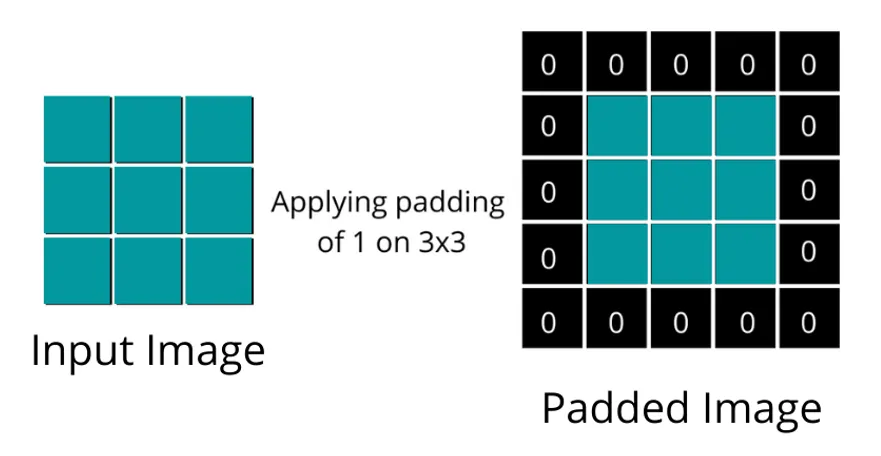

Max pooling takes the maximum value from each patch of the feature map.
Average pooling takes the average value from each patch of the feature map.

This operation reduces the size of the feature map by half, both horizontally and vertically, but retains the most prominent features.

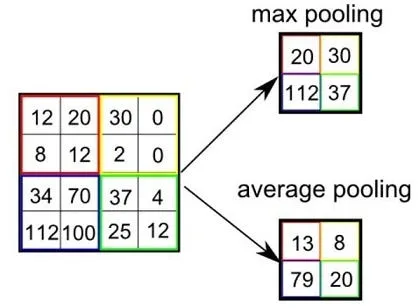

In [8]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # First convolutional block
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        # Second convolutional block
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        # Max pooling and dropout
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.dropout_fc = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))  # Conv1 -> BN -> ReLU -> Pool
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))  # Conv2 -> BN -> ReLU -> Pool
        x = self.dropout(x)  # Apply dropout after conv blocks
        x = x.view(-1, 64 * 8 * 8)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.dropout_fc(x)  # Dropout in FC layer
        x = self.fc2(x)
        return x

 Model Summary with `torchsummary`

To get a layer-by-layer breakdown of your custom PyTorch model, you can use the `torchsummary` package. This is especially useful to understand the number of parameters, shapes, and types of layers used.

Make sure you have already installed `torchsummary`

In [9]:
from torchsummary import summary

net = SimpleCNN()
summary(net, input_size=(3, 32, 32), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
       BatchNorm2d-5           [-1, 64, 16, 16]             128
         MaxPool2d-6             [-1, 64, 8, 8]               0
           Dropout-7             [-1, 64, 8, 8]               0
            Linear-8                  [-1, 512]       2,097,664
           Dropout-9                  [-1, 512]               0
           Linear-10                   [-1, 10]           5,130
Total params: 2,122,378
Trainable params: 2,122,378
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.88
Params size (MB): 8.10
Estimat

## Step 4: Instantiate the Model, Define Loss Function and Optimizer

Now that we’ve defined our CNN class, we:
- Instantiate the model
- Choose a **loss function** suitable for multi-class classification: `CrossEntropyLoss`
- Use **Stochastic Gradient Descent (SGD)** as our optimizer

These components are necessary to begin training the model.

In [12]:
# get gpu if available else cpu:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [13]:
# Create an instance of our CNN
net = SimpleCNN()

# Loss functiona, Optimizer and Scheduler
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-5)

## Step 5: Train the CNN

We'll train the model over 2 epochs.
In each epoch, we:
- Loop over the training dataset in batches
- Perform a forward pass
- Compute the loss
- Backpropagate the error
- Update the model parameters

We print the loss every 200 mini-batches to track learning progress.

After each training epoch, we also evaluate the model on a separate **validation set**.
This helps monitor the model's generalization and detect overfitting early.

In [14]:
net = net.to(device)

In [15]:
for epoch in range(2):  # loop over the dataset multiple times

    net.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

    # 🔍 Validation phase after each epoch
    net.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for val_inputs, val_labels in valloader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = net(val_inputs)
            vloss = criterion(val_outputs, val_labels)
            val_loss += vloss.item()
            _, predicted = torch.max(val_outputs.data, 1)
            total += val_labels.size(0)
            correct += (predicted == val_labels).sum().item()

    val_acc = 100 * correct / total
    avg_val_loss = val_loss / len(valloader)

    print(f'Validation after Epoch {epoch + 1} → Loss: {avg_val_loss:.4f}, Accuracy: {val_acc:.2f}%\n')

print('Finished Training')

Validation after Epoch 1 → Loss: 1.2194, Accuracy: 56.60%

Validation after Epoch 2 → Loss: 1.0650, Accuracy: 62.21%

Finished Training


## Step 6: Evaluate the Model on Test Data

Now we evaluate the model's performance on **unseen test data**.

We:
- Disable gradient calculation for efficiency
- Predict classes for each test image
- Compare predictions with true labels
- Calculate the overall classification accuracy

In [16]:
# Initialize counters
correct = 0
total = 0

# Turn off gradient tracking for evaluation
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device) #to device
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)  # Get index of max log-probability
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Compute and print accuracy
accuracy = 100 * correct / total
print(f'Accuracy of the network on the 10000 test images: {accuracy:.2f}%')

Accuracy of the network on the 10000 test images: 61.89%


## Visualizing CNN Kernels and Feature Maps

To understand what the CNN is learning, we can visualize:
- **Kernels (filters)**: The raw weights of convolution layers
- **Feature maps (activations)**: What the filters detect in a specific input image

These help us build intuition about how the model 'sees' the image at each stage.

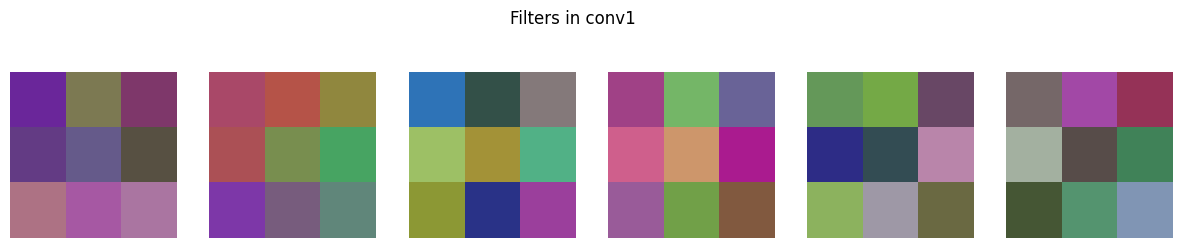

In [17]:
import matplotlib.pyplot as plt

# Get the weights and normalize to [0, 1]
filters = net.conv1.weight.data.clone().cpu()
filters = (filters - filters.min()) / (filters.max() - filters.min())

# Plot first 6 filters
fig, axes = plt.subplots(1, 6, figsize=(15, 3))
for i in range(6):
    axes[i].imshow(filters[i].permute(1, 2, 0))  # convert CHW to HWC
    axes[i].axis('off')
plt.suptitle('Filters in conv1')
plt.show()

### Feature Maps (Activations)

Now we visualize how the CNN responds to an image by displaying feature maps generated by the first conv layer.


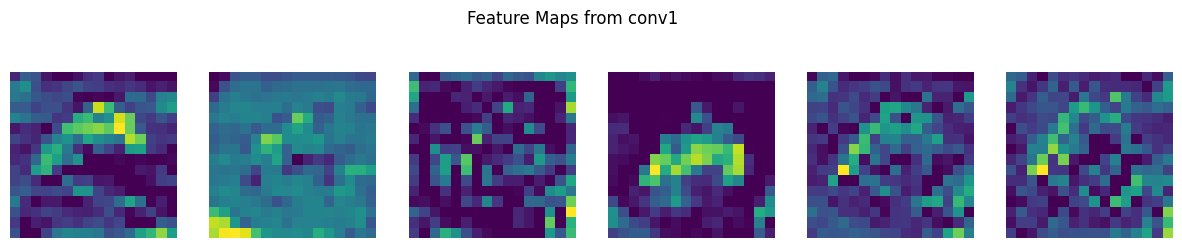

In [18]:
# Choose one sample image from CIFAR-10
image, label = trainset[0]
input_img = image.unsqueeze(0).to(device)  # Add batch dimension

# Pass through first conv layer and visualize
net.eval()
with torch.no_grad():
    activation = net.pool(torch.relu(net.bn1(net.conv1(input_img))))

# Remove batch dimension and convert to CPU
features = activation.squeeze().cpu()

# Plot first 6 feature maps
fig, axes = plt.subplots(1, 6, figsize=(15, 3))
for i in range(6):
    axes[i].imshow(features[i] ) #cmap='gray'
    axes[i].axis('off')
plt.suptitle('Feature Maps from conv1')
plt.show()

## Using a pretrained model like ResNet18

In this section, we explore a pretrained **ResNet18** model from `torchvision.models`.


Instead of training a CNN from scratch, we can reuse the **feature extraction layers** of a model trained on a large dataset (like ImageNet), and only retrain the final layer(s) for our own task.

**Benefits:**
- Much faster training
- Requires less data
- Often achieves higher accuracy

We use **[ResNet18](https://pytorch.org/hub/pytorch_vision_resnet/)**, a deep residual network, pretrained on ImageNet.

---

In [19]:
# Import ResNet18 from torchvision
from torchvision import models
import torch.nn as nn

# Load pretrained ResNet18
model = models.resnet18(pretrained=True)

# Freeze all layers except the final layer
for param in model.parameters():
    param.requires_grad = False

# Modify the final fully connected layer of ResNet-18 to match CIFAR-10
#In the case of ResNet18, the last layer is nn.Linear(512, 1000)

num_ftrs = model.fc.in_features


# The new linear layer has num_ftrs input features and 10 output features (for 10 classes)
model.fc = nn.Linear(num_ftrs, 10)

model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 85.1MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
# Training loop
num_epochs = 2
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(trainloader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(valloader)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

Epoch 1/2, Train Loss: 2.6235, Val Loss: 2.6795
Epoch 2/2, Train Loss: 2.6226, Val Loss: 2.6803


###Loss function and Learning Curve
The loss function measures how well a machine learning model's predictions match the actual outcomes, with the goal of minimizing this error during training. The learning curve plots the loss against the number of training epochs, showing the model's performance improvement over time. By visualizing these curves, we can diagnose issues like overfitting or underfitting and adjust the training process accordingly.

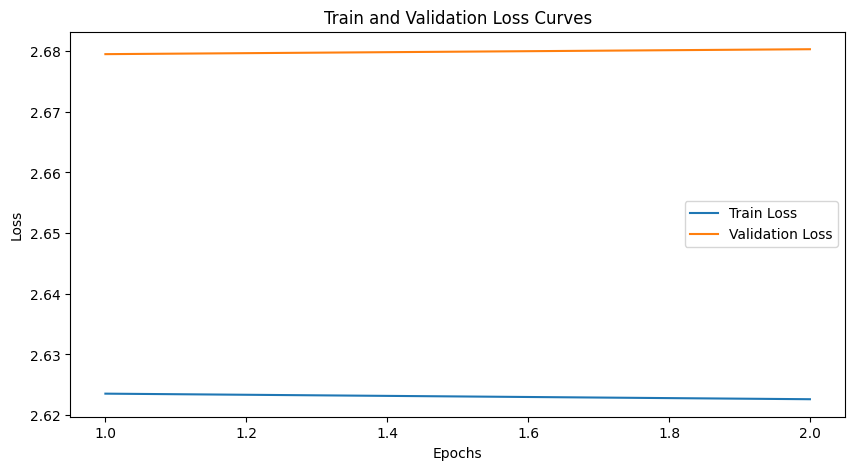

In [21]:
# Plotting the loss curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss Curves')
plt.show()

## Task 1 – Description

Implement a CustomCNN class that builds a convolutional neural network with the following layers:

Conv2d(3, 32, kernel_size=3, padding=1), ReLU, MaxPool2d(2,2)

Conv2d(32, 64, kernel_size=3, padding=1), ReLU, MaxPool2d(2,2)

Flatten

Linear(64×8×8, 128), ReLU, Dropout(0.3)

Linear layer taking 128 inputs with 10 outputs

Note: torch.nn is already imported as nn, and you may use functional components from F.

In [24]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()

        # First convolutional block
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)

        # Second convolutional block
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.relu_fc = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))  # Conv -> ReLU -> Pool
        x = self.pool2(self.relu2(self.conv2(x)))  # Conv -> ReLU -> Pool
        x = x.view(-1, 64 * 8 * 8)                 # Flatten
        x = self.relu_fc(self.fc1(x))              # FC -> ReLU
        x = self.dropout(x)                        # Dropout
        x = self.fc2(x)                            # Final FC
        return x

---

*End of Task 1. Copy your final code to **Homework 3 - Code** on **NextIlearn***